# Functions

In [122]:
#%run "../Notebooks/initialization.ipynb"
%run "../Notebooks/Stitching_functions.ipynb"
%run "../Notebooks/Visualization_functions.ipynb"
%run "../Notebooks/Downsampling_and_outliers_functions.ipynb"
%load_ext autoreload

loaded variables: 
myparams, myconfiguration_file
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sort sequences appropriately

In the first set of teeth we got 30 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0
- seq_3: upper images are sorted as 0 to 9

In the second set of teeth we got 20 images in sequences of 10:
- seq_1: external images are sorted as 0 to 9
- seq_2: internal images are sorted as 9 to 0

The data is taken with a intradental camera which moves from one side to the other of the mounth, with small movements (2-5mm) which need to guarantee enough overlapping between the pictures/point clouds to allow proper reconstruction. 

From a quick look at the pictures we notice that we always need to reverse the order of the second sequence (seq_2) images and ply.


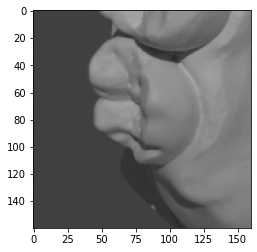

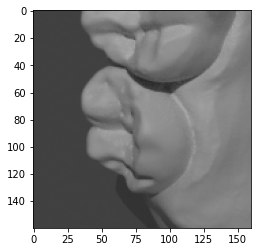

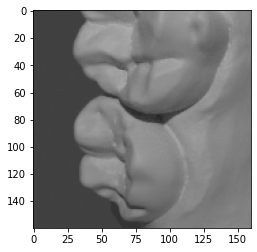

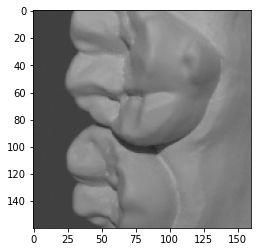

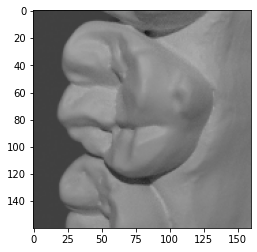

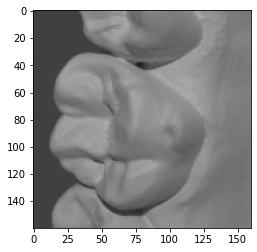

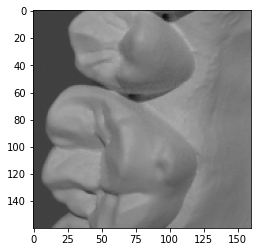

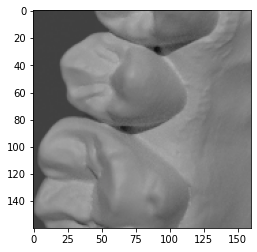

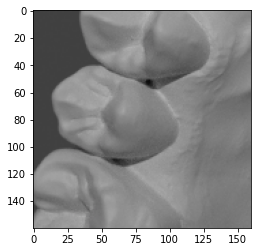

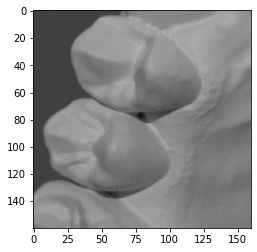

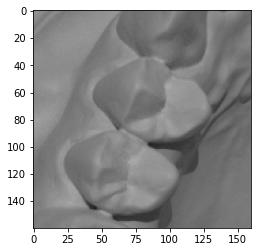

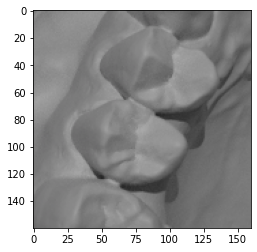

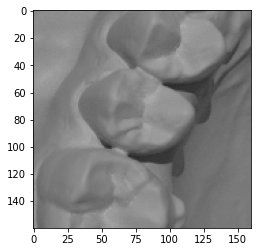

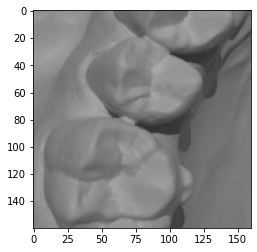

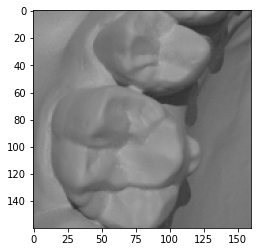

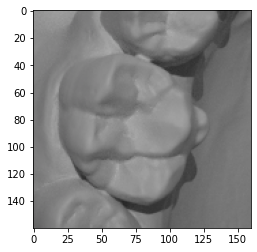

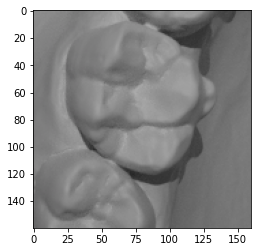

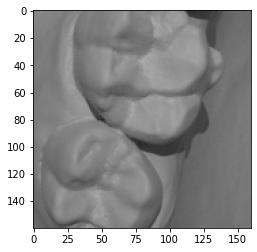

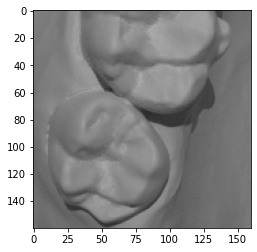

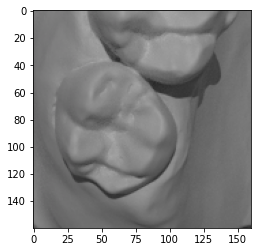

In [131]:
all_img = [cv2.imread(path) for path in all_paths_images[:]]

for ima in all_img:
    plt.figure()
    plt.imshow(ima)

In [139]:
num_teeth = 10
external_img = [cv2.imread(path) for path in all_paths_images[:num_teeth]]
internal_img = [cv2.imread(path) for path in all_paths_images[num_teeth:2*num_teeth]]
#upper_img = [cv2.imread(path) for path in all_paths_images[-num_teeth:]]

In [140]:
## reverse in place the internal ones
internal_img.reverse()

# plot tooth

In [137]:
t = 1

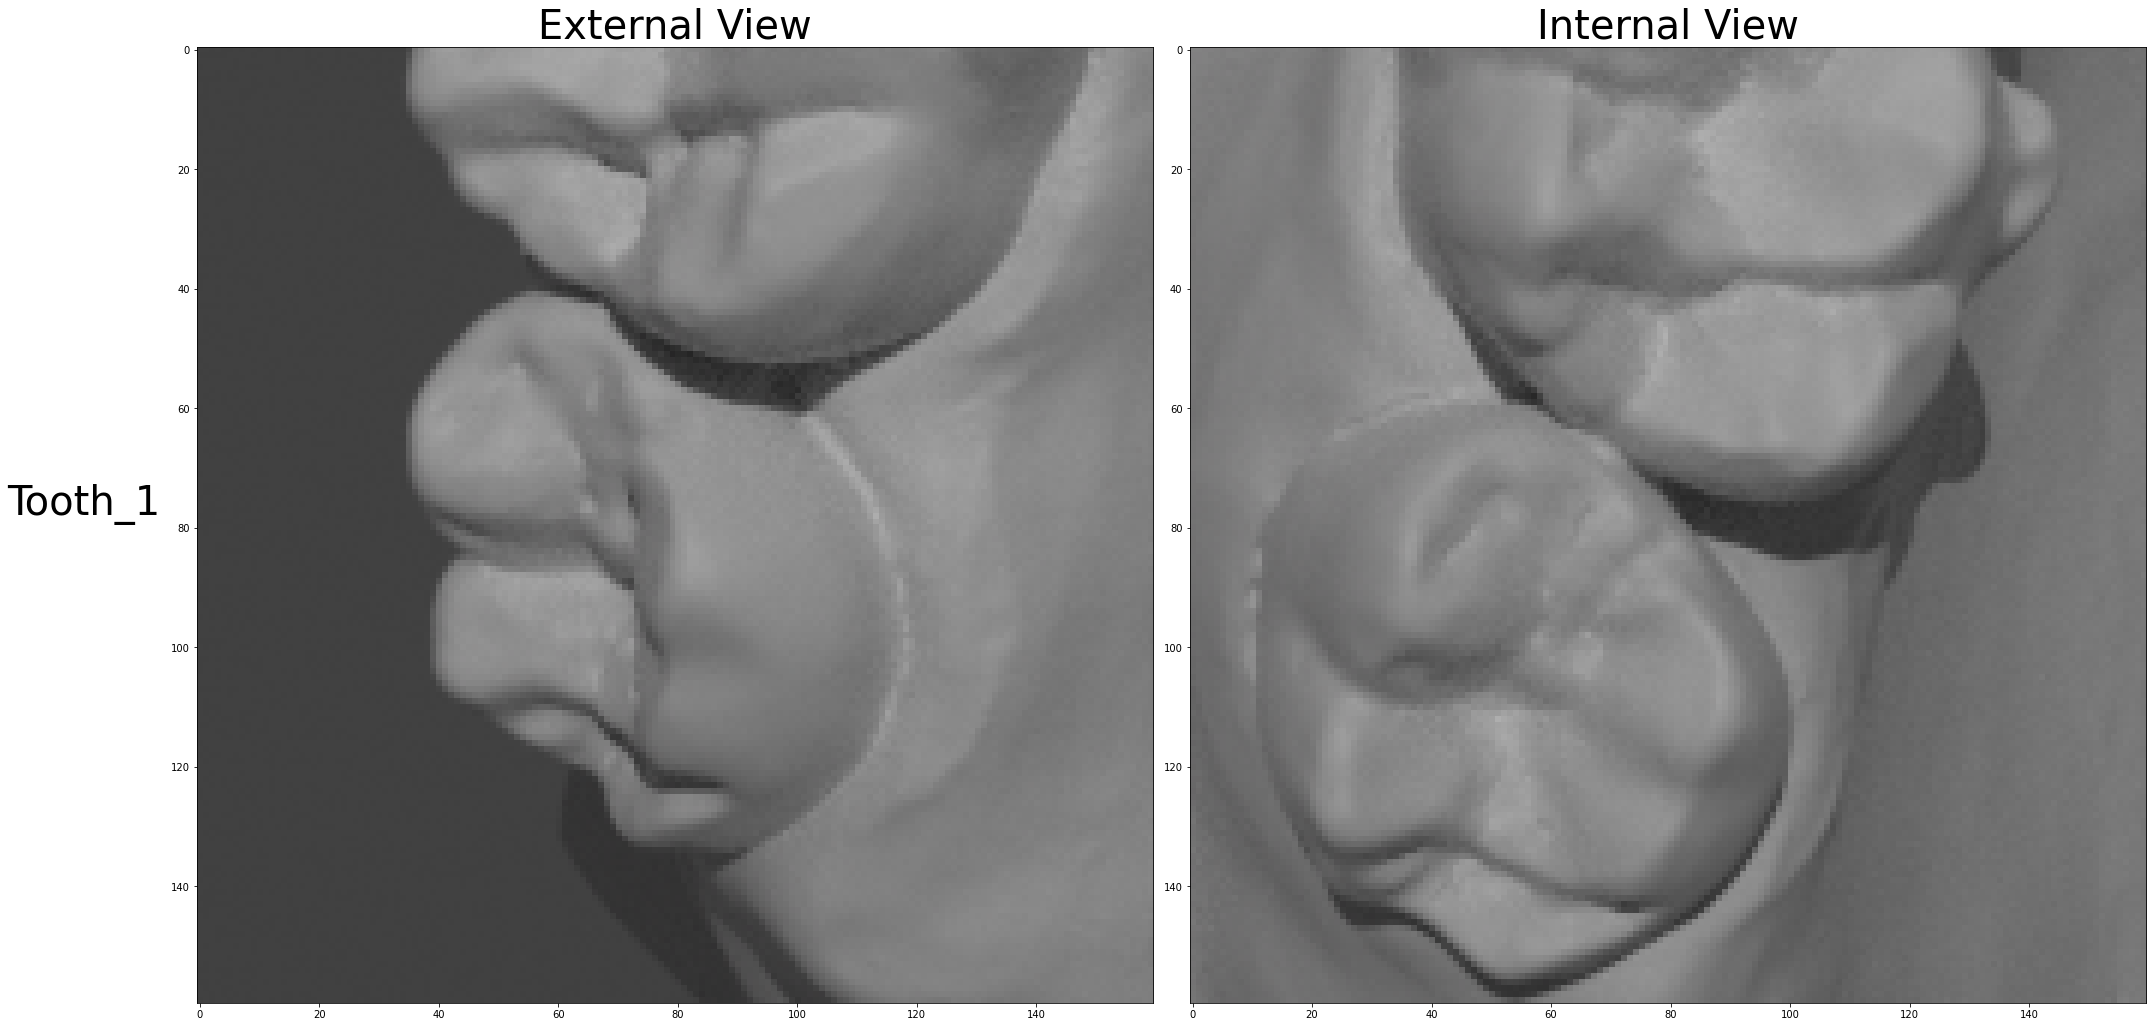

In [141]:
one_tooth_images= [
                   external_img[t],
                   internal_img[t],
                   #upper_img[t]
                  ]

display_one_tooth(one_tooth_images,toothnum = t, rows = 1, cols=len(one_tooth_images))


# plot multiple teeth

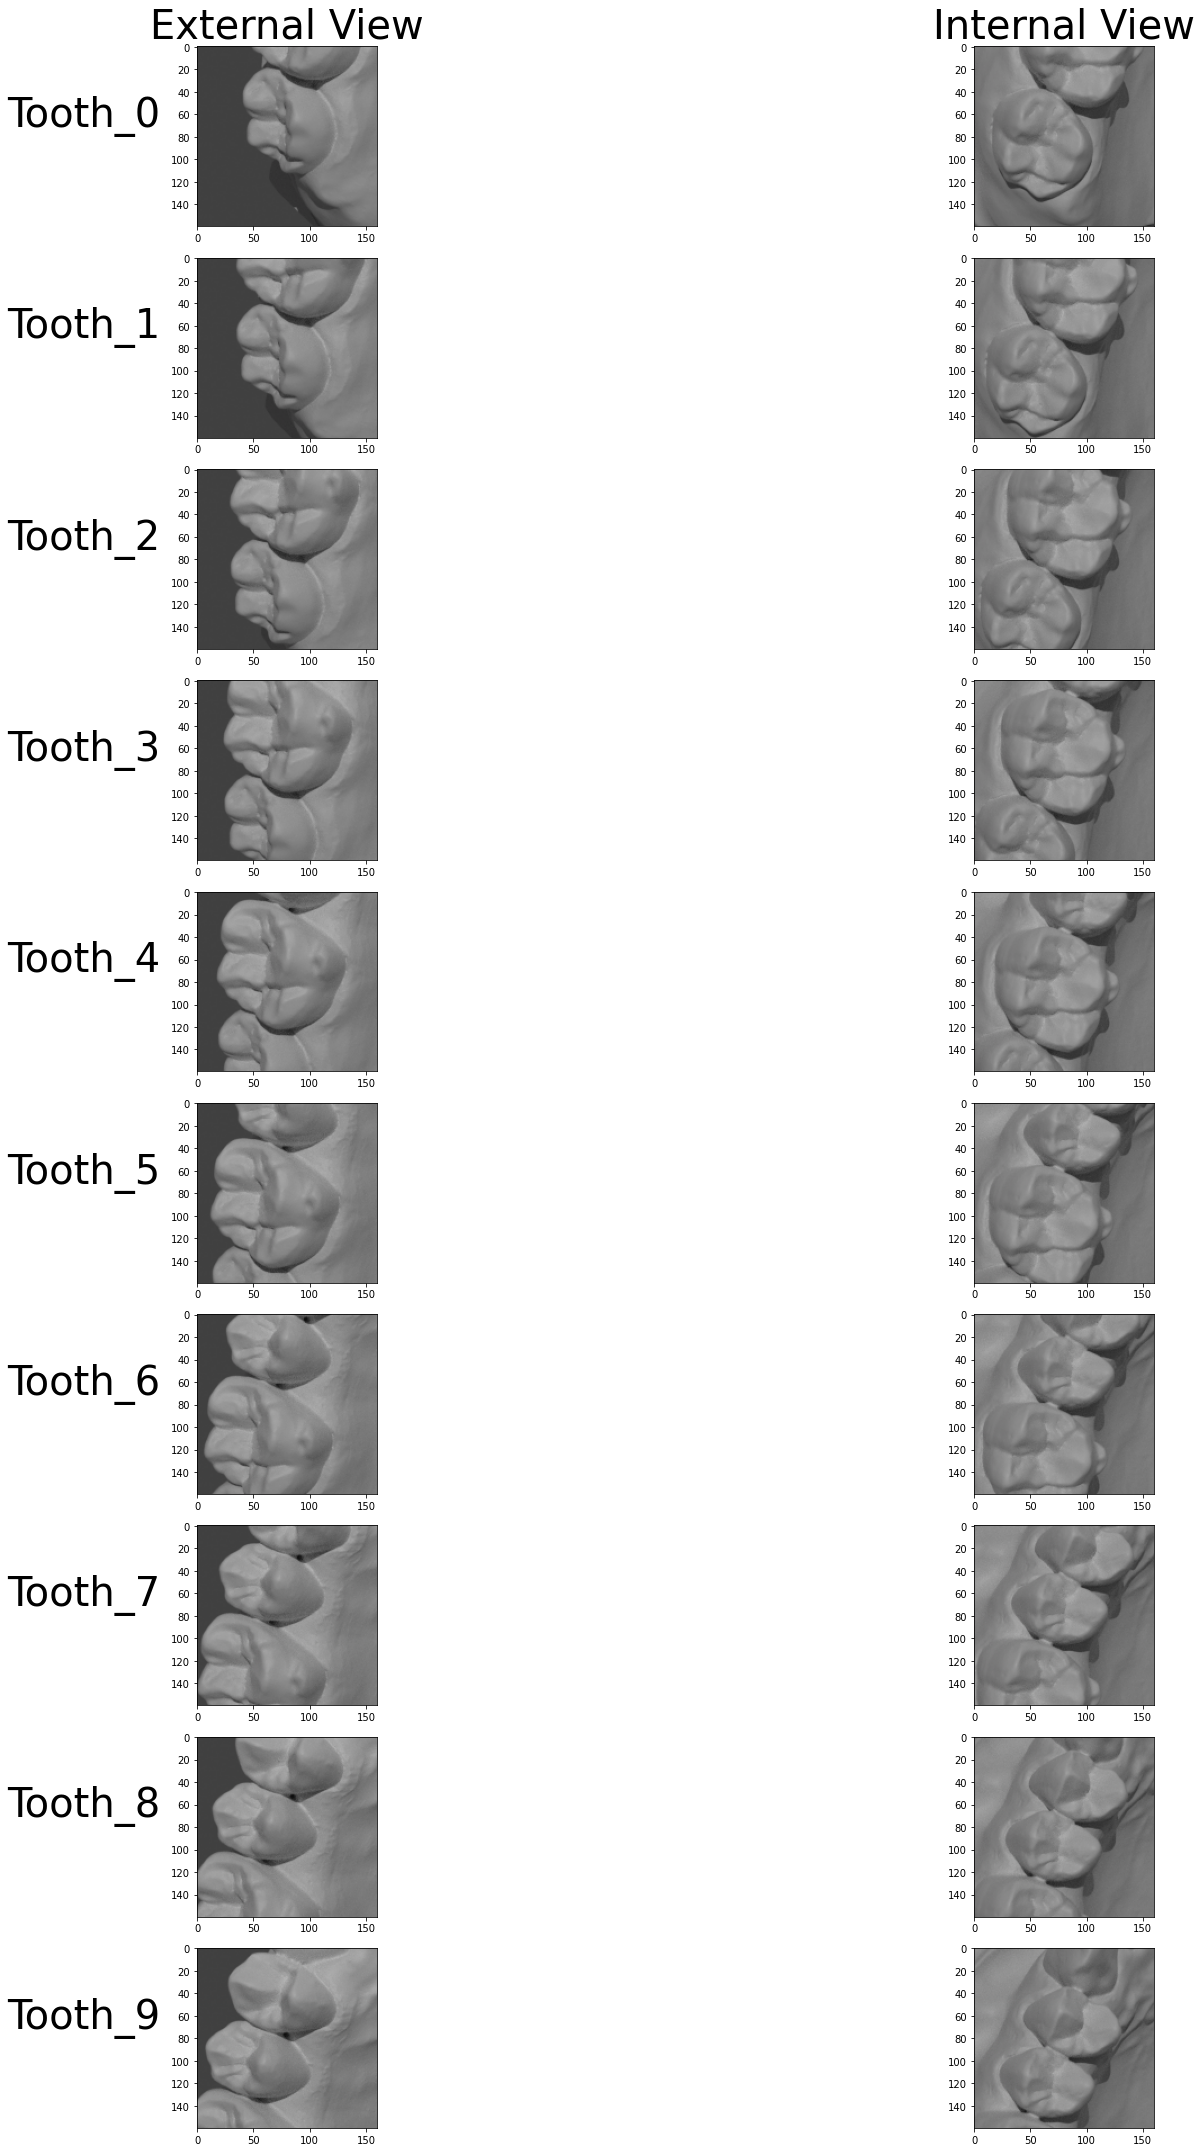

In [142]:
T = (0,11) # visualizing teeth from 1 to 10
many_images= [external_img[T[0]:T[1]], 
              internal_img[T[0]:T[1]], 
              #upper_img[T[0]:T[1]]
             ] 
display_multiple_teeth(many_images,T, rows = len(upper_img[T[0]:T[1]]), cols=len(many_images))

# Load Point Clouds

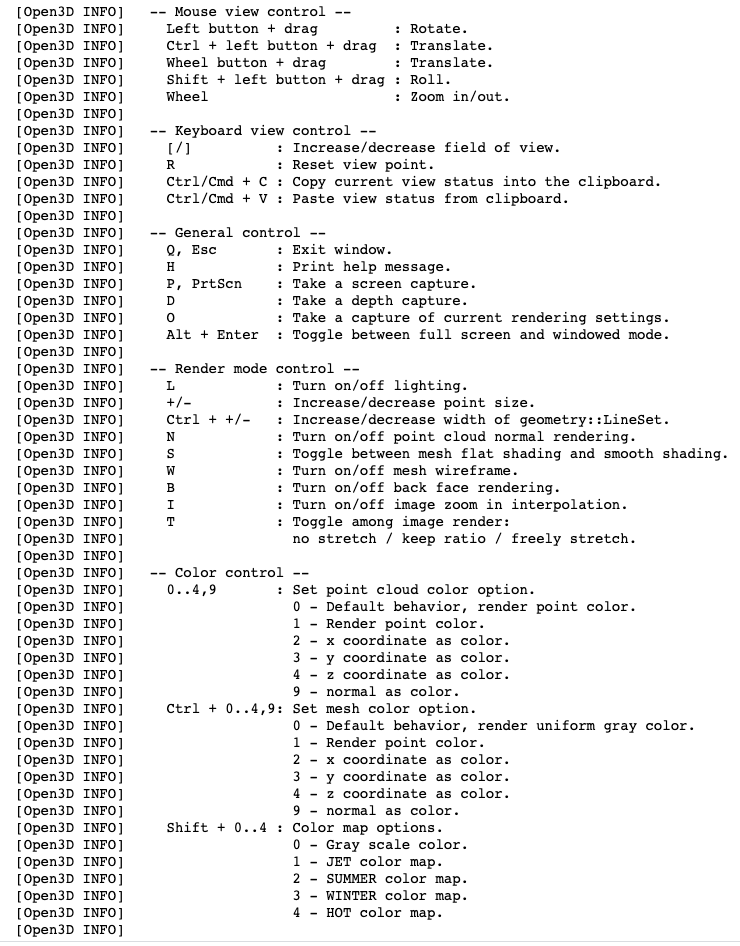

In [83]:
# instructions
Im(filename='instructions.png',
  width = 500) 

### load one point cloud 

In [149]:
#load one point cloud 
# http://www.open3d.org/docs/release/python_api/open3d.geometry.PointCloud.html
test_num = 18
path = ply_folder+"/"+all_ply[test_num]
pcd = o3d.io.read_point_cloud(path)
print(pcd)
## how to access the points
print(np.asarray(pcd.points))

PointCloud with 25034 points.
[[-8.703826 -8.703826 44.407273]
 [-8.581762 -8.690391 44.338732]
 [-8.460229 -8.677158 44.271216]
 ...
 [10.349707 10.618531 54.861951]
 [10.494036 10.628575 54.913847]
 [10.626841 10.626841 54.904886]]


### visualize point cloud- default function

In [150]:
#simple point cloud visualization 
### visualize point cloud- opens a pop up window
mytitle = "generic_visualization"
o3d.visualization.draw_geometries([pcd],
                                 width=1000, height=800,
                                 window_name='%s'%(mytitle))


> Save configuration file as .json with O

> Save picture(png) and camera(json) with pov with P

### visualize point could -custom made

In [152]:
custom_draw_geometry(pcd, 
                         mytitle =  "generic_visualization", mytuples = None,
                         params =None, 
                         configuration_file = None, 
                         take_screen_shot = False,
                         rotate = True)

[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [153]:
# https://github.com/intel-isl/Open3D/issues/1483
custom_draw_geometry(pcd, # point cloud
                     mytitle =  "visualization with given parameters",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = False,
                     rotate = False) # with rotate true the config arent read

### downsampling

The higher the voxel size the less points we have. 

In [154]:
down_pcd = pcd.voxel_down_sample(voxel_size=0.3)
print ("number of points with voxel down sample" ,len(np.array(down_pcd.points)))
#o3d.visualization.draw_geometries([down_pcd.paint_uniform_color([0.8, 0.8, 0.8])])

number of points with voxel down sample 7236


### outlier removal

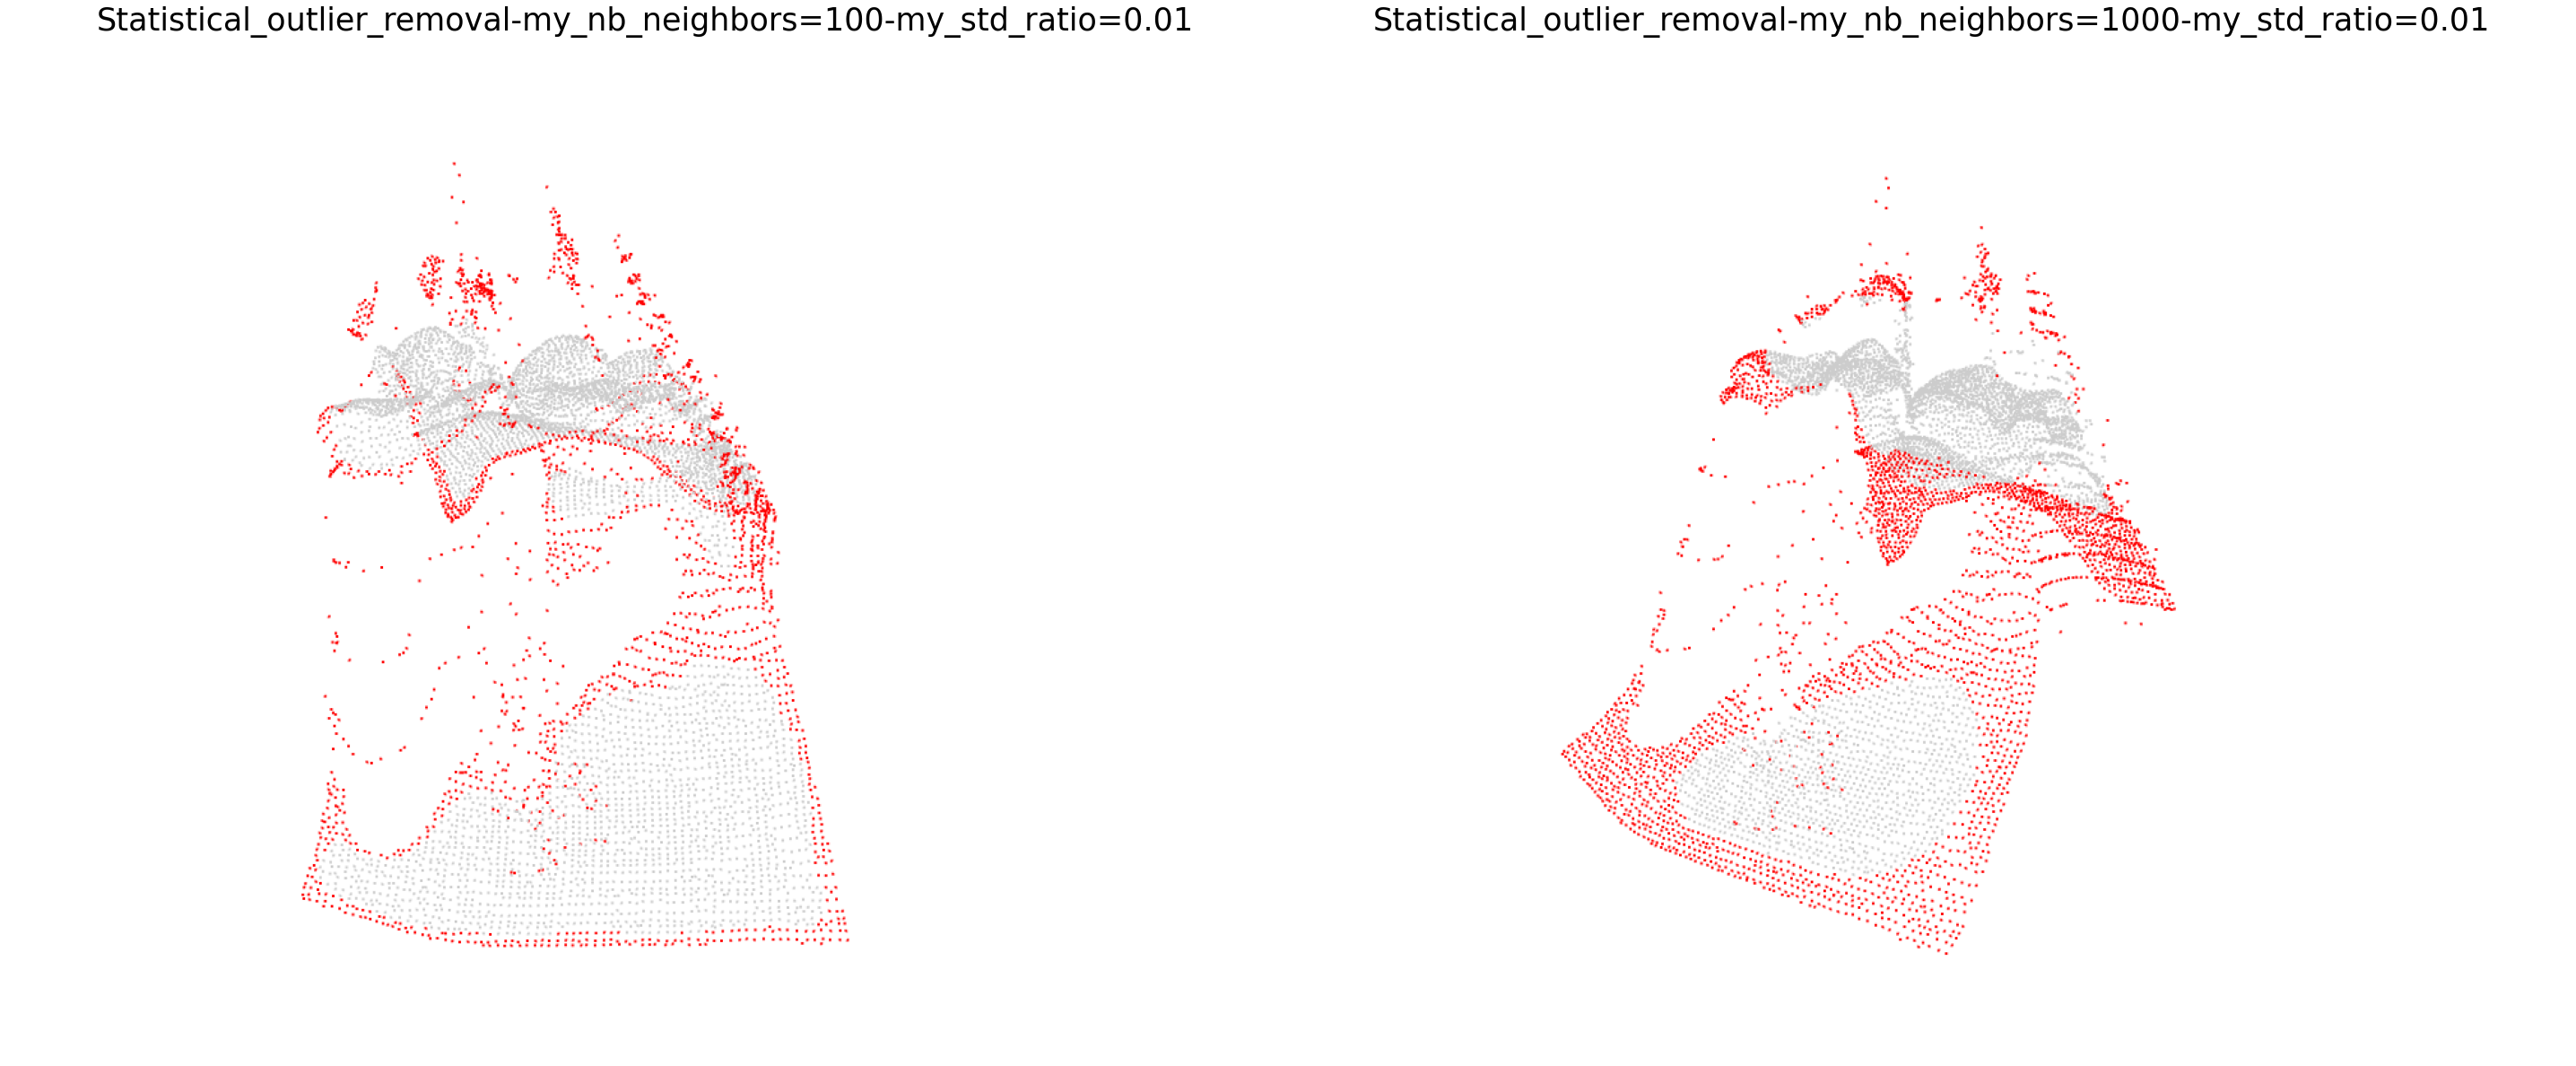

In [155]:
### Statistical oulier removal
# effect is to highlight the contours
# increasing the number of neightbors more outliers in the countours
# de creasing the number std_ratio gives wider contours
mytitle ="Statistical_outlier_removal"

# check how different parameters influence the outlier removal
my_nb_neighbors=[100,1000]
my_std_ratio=[0.01,0.01]

my_n = len(my_std_ratio)


for i in range(my_n):
    
    parameters = (my_nb_neighbors[i],my_std_ratio[i])
    parameters_labels = ("my_nb_neighbors","my_std_ratio")
    mytuples = list(zip(parameters_labels,parameters))

    cloud, ind = down_pcd.remove_statistical_outlier(nb_neighbors=my_nb_neighbors[i],
                                                    std_ratio=my_std_ratio[i])
    display_inlier_outlier(down_pcd, ind, 
                           mytitle, mytuples,
                           params =myparams, 
                           configuration_file = myconfiguration_file, 
                           take_screen_shot = True,
                           rotate = False,
                           onewindow = True
                          )
# visualization
paths_temp = last_n_files_containing("Statistical",n= myn, extension = '.png')
img_temp = [cv2.imread(path) for path in paths_temp]

rows = 1
cols = myn
fig, axes = plt.subplots(nrows=rows,ncols=cols,squeeze=False,figsize=(40, 40))
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(plt_format(img_temp[j]))
        axes[i][j].set_title(paths_temp[j][2:-4],fontsize = 35)
        axes[i][j].axis('off')

fig.tight_layout()    
plt.show()

## custom visualization of outliers 

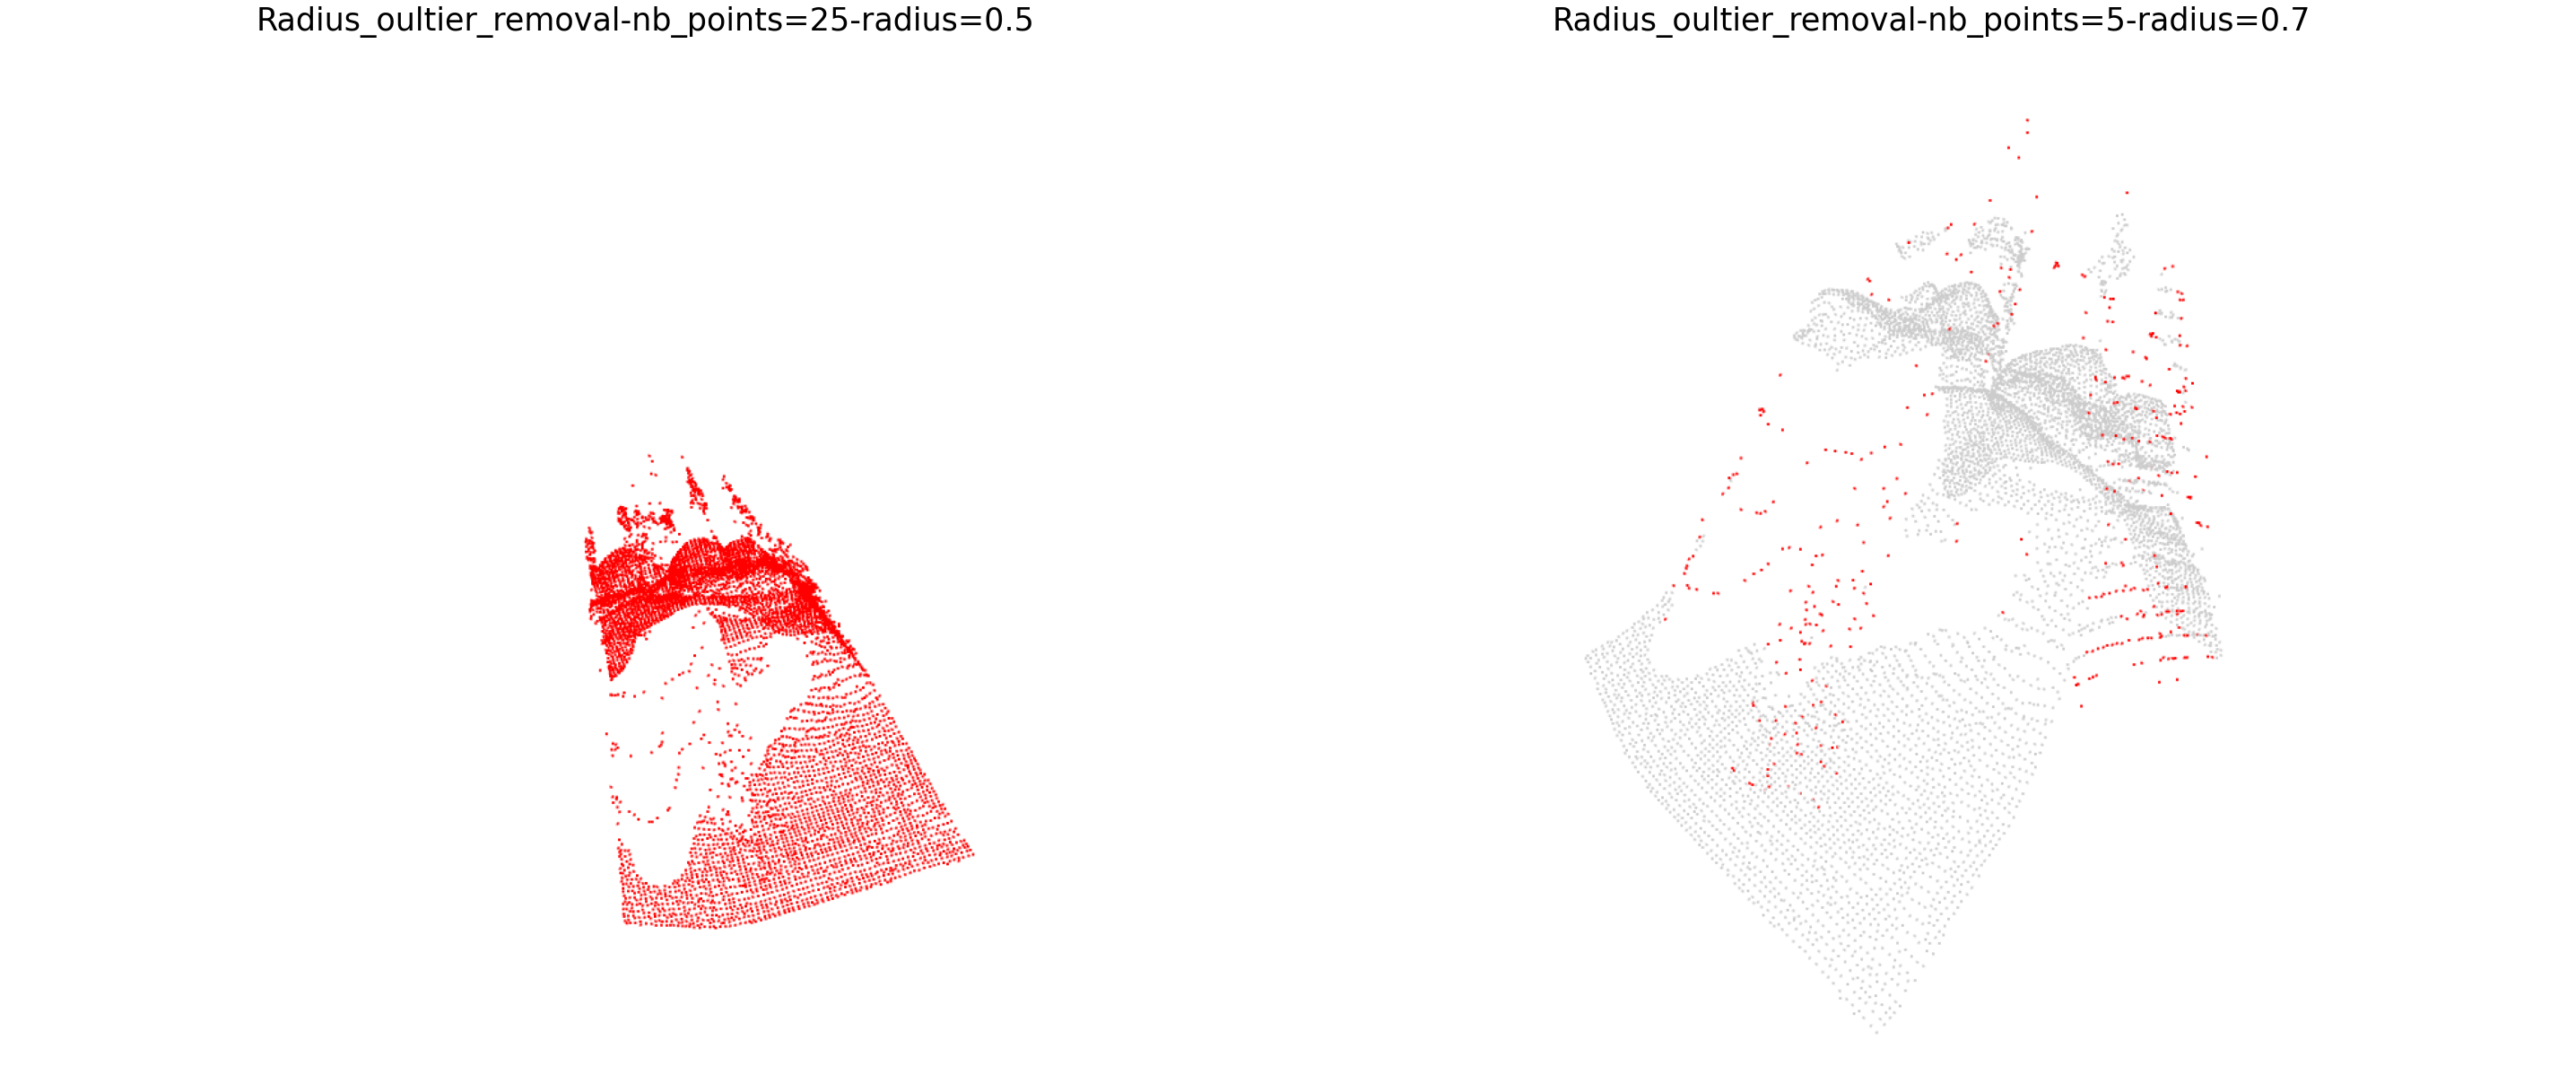

In [162]:
### Radius oulier removal
mytitle = "Radius_oultier_removal"

#test with different parameters
nb_points = [10,25]
radius = [0.2,0.5]

my_n = len(nb_points)
for i in range(my_n):
    
    parameters = (nb_points[i],radius[i])
    parameters_labels = ("nb_points","radius")
    mytuples = list(zip(parameters_labels,parameters))

    cloud, ind = down_pcd.remove_radius_outlier(parameters[0], parameters[1])
    
    display_inlier_outlier(down_pcd, ind, 
                           mytitle, mytuples,
                           params =myparams, 
                           configuration_file = myconfiguration_file, 
                           take_screen_shot = True,
                           rotate = False,
                           onewindow = True)

#visualization  
paths_temp = last_n_files_containing("Radius",n= myn, extension = '.png')
img_temp = [cv2.imread(path) for path in paths_temp]

rows = 1
cols = myn
fig, axes = plt.subplots(nrows=rows,ncols=cols,squeeze=False,figsize=(40, 40))
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(plt_format(img_temp[j]))
        axes[i][j].set_title(paths_temp[j][2:-4],fontsize = 35)
        axes[i][j].axis('off')

fig.tight_layout()    
plt.show()
#display_inlier_outlier(down_pcd, ind)

loading parameters: 
  ./ScreenCamera_2021-01-13-01-29-21.json
Field of view (before changing) 60.00
Field of view (after changing) 75.00
loading configuration file: 
  ./RenderOption_2021-01-12-13-09-05.json


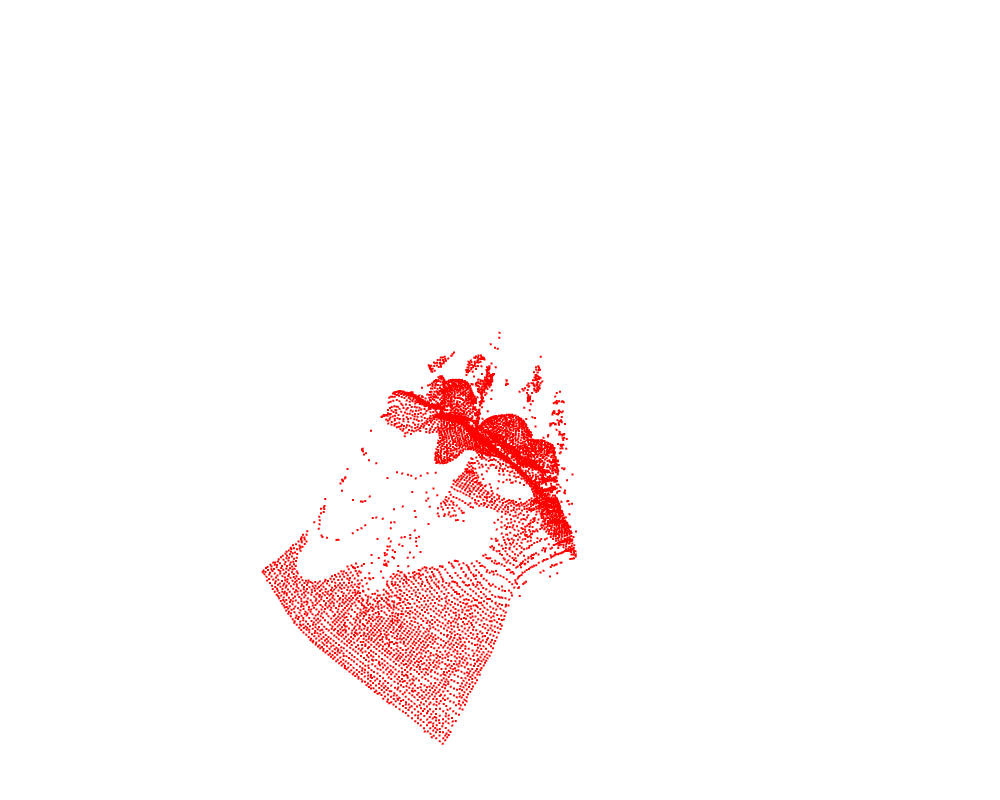

In [159]:
custom_draw_geometry_outliers(down_pcd, ind, 
                              mytitle = "Radius_oulier_removal", mytuples = mytuples,
                              params = myparams,  # parameter for camera point view, json file via pressing P
                              take_screen_shot = False,
                              configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                              fov_step  = 15,
                              rotate = "interactive")

Im(filename=last_file(".png"),
  width = 500, height = 400) 

39.79776370552528
Define parameters used for hidden_point_removal
Get all points that are visible from given view point
loading parameters: 
  ./ScreenCamera_2021-01-13-01-29-21.json
loading configuration file: 
  ./RenderOption_2021-01-12-13-09-05.json


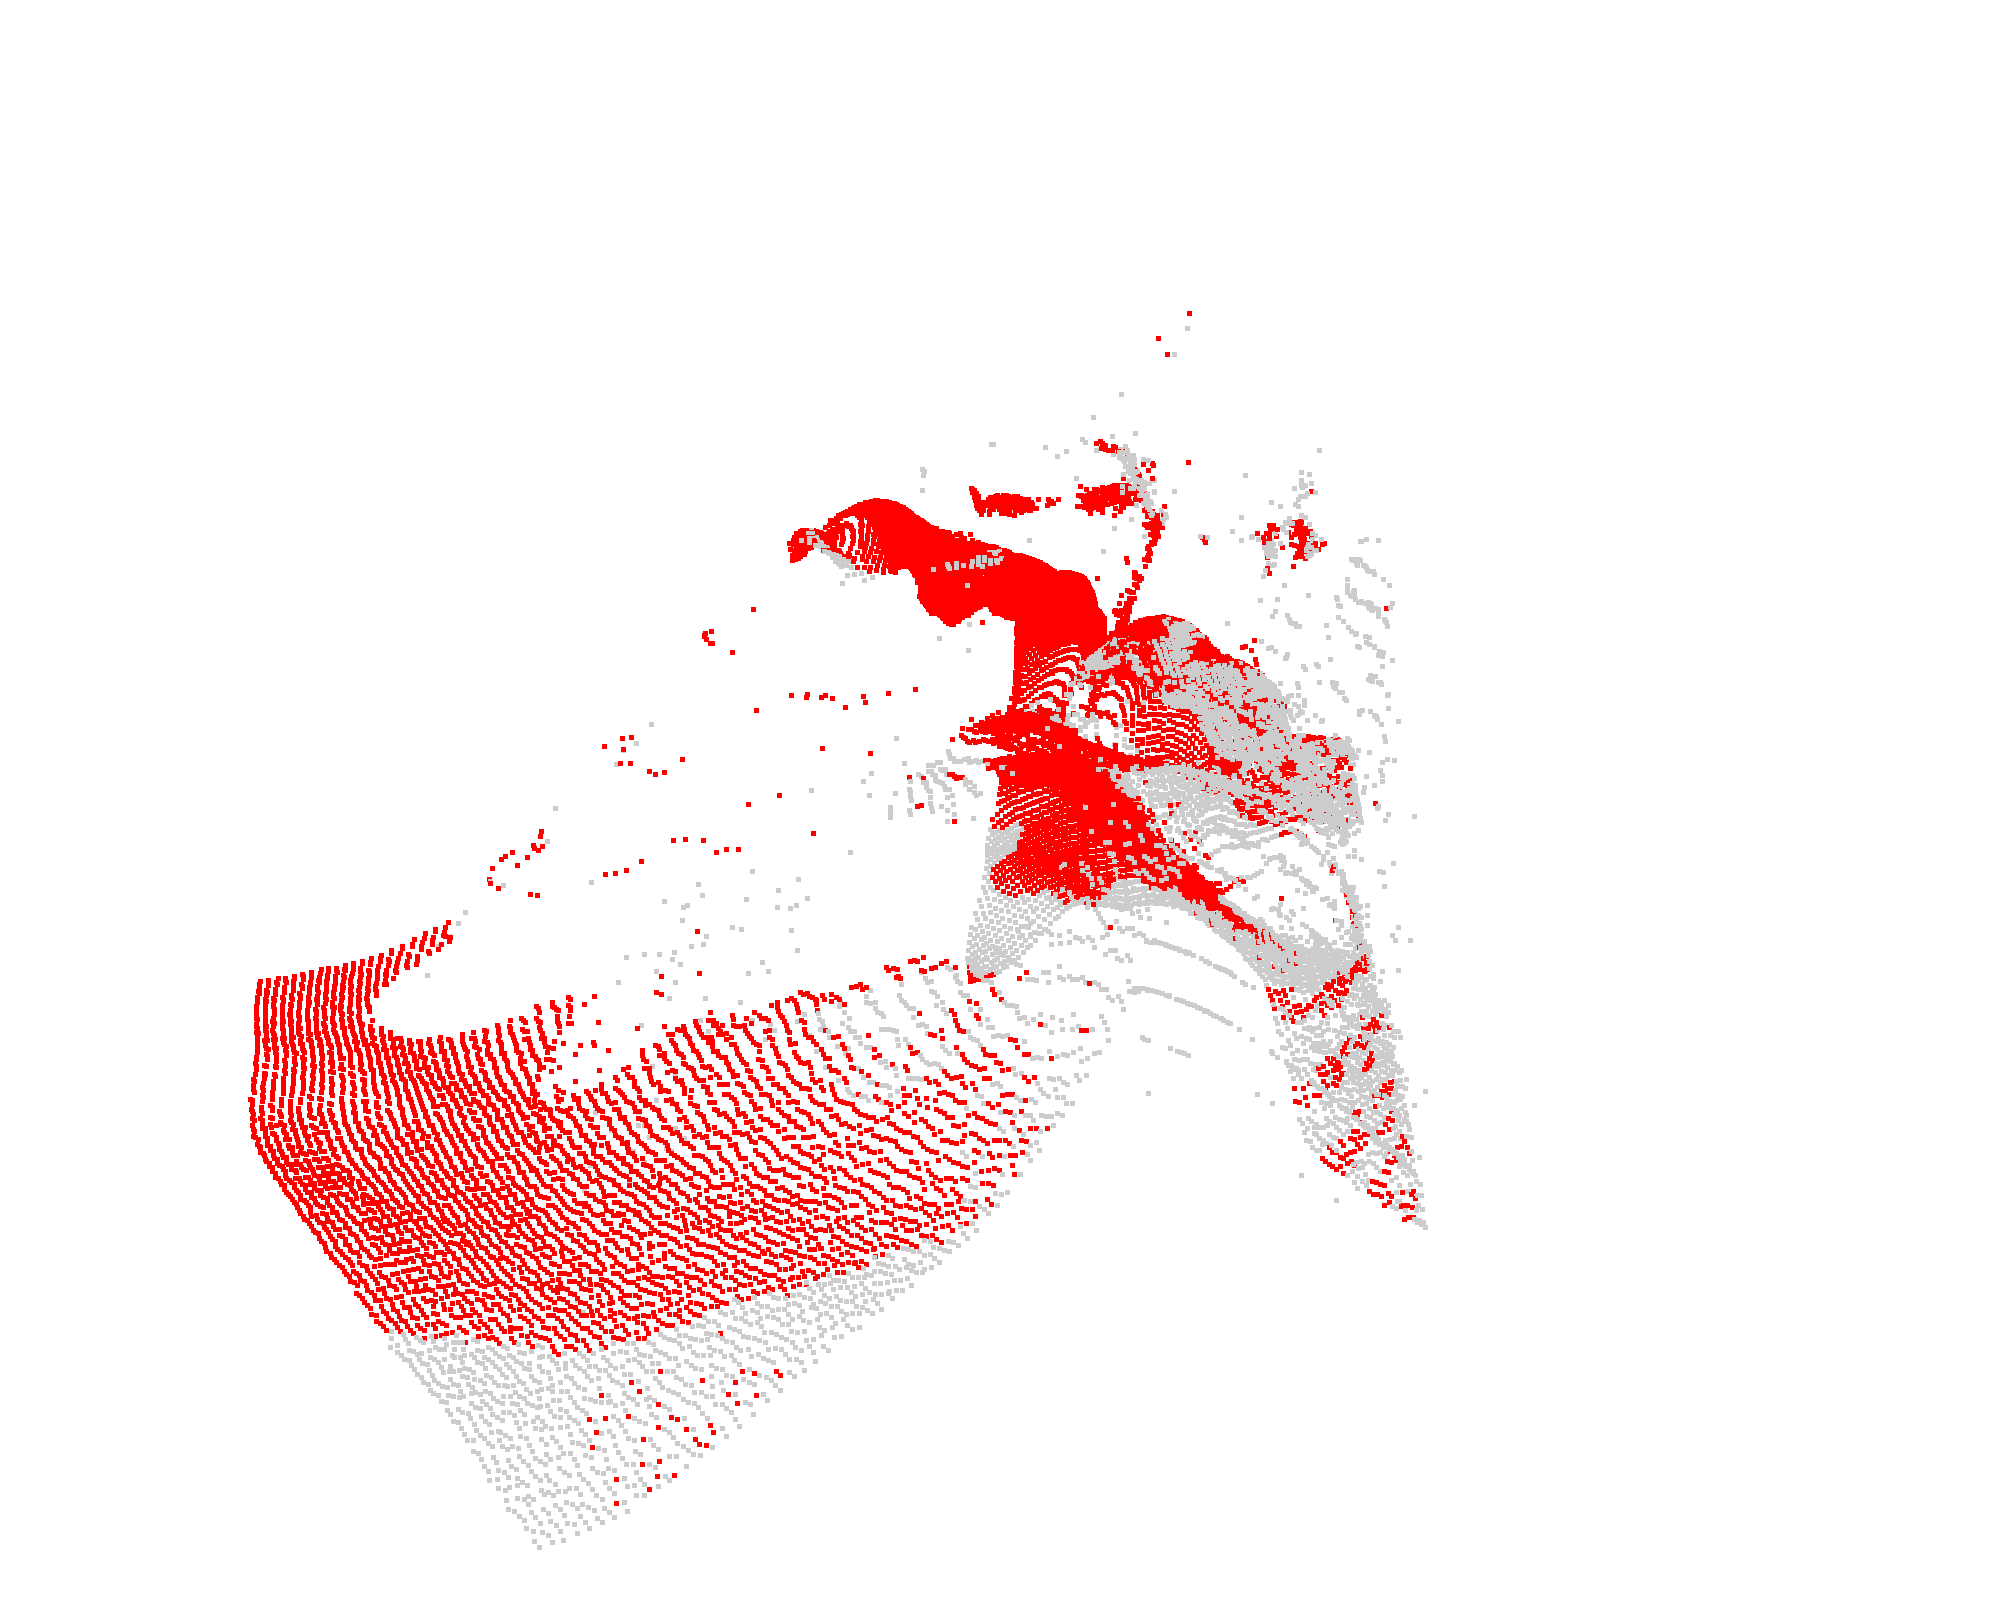

In [161]:
### hidden points removal
diameter = np.linalg.norm(
                          np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
print (diameter)
print("Define parameters used for hidden_point_removal")
a = 10
b = 0
camera = [a, b, diameter]
radius = diameter * 200

print("Get all points that are visible from given view point")
pcd_clean, pt_map = pcd.hidden_point_removal(camera, radius)

#print("Visualize result")
custom_draw_geometry_outliers(pcd, pt_map, 
                              mytitle = "Radius_oulier_removal", mytuples = mytuples,
                              take_screen_shot = False,
                              params = myparams,  # parameter for camera point view, json file via pressing P
                              configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                              #fov_step  = 15,
                              rotate = "interactive")

Im(filename=last_file(".png"),
  width = 500, height = 400) 